In [22]:
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
import versor as vsr
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
# sns.set_context('paper')
from versor.drawing import *
from motor_estimation import MotorEstimationSolver
from game import VDMotorEstimationSolver
from icp import best_fit_transform
import pickle

Populating the interactive namespace from numpy and matplotlib


/Users/lars/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['Inf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [23]:
def create_motors(n_motors=10, d_lims=(0,10), th_lims=(0,pi)):
    motors = [((vsr.Vec(*np.random.random(3)).unit() * np.random.uniform(*d_lims)).trs() * 
               vsr.Rot(vsr.Biv(*np.random.uniform(-1,1,3)).unit() * np.random.uniform(*th_lims) * -0.5)) 
              for i in range(n_motors)]
    return motors

In [24]:
def create_points(motor, gaussian=False, radius=10, n_points=10, points_std=0.8, noise_std=0.09):
    points = []
    for i in range(n_points):
        if gaussian:
            a = vsr.Vec(*np.random.normal(0.0, points_std,3)).null()
        else:
            a = (vsr.Vec(*np.random.uniform(-1,1,3)).unit() * np.random.uniform(0,radius)).null()
        b = a.spin(motor)
        t = vsr.Vec(*np.random.random(3)).unit() * np.random.normal(0.0,noise_std,1)
        noise_motor = t.trs() * vsr.Rot(1,0,0,0)
        bn = a.spin(noise_motor).spin(motor)
#         bn = vsr.Vec(*(np.array(a)[:3] + np.random.normal(0,noise_std,3))).null().spin(motor)
        points.append((a,b,bn))

    return (points, motor)

In [25]:
def create_random_lines(motor, n_lines=10, radius=10, 
                        trs_noise_std=0.09, rot_noise_std=0.09):
    lines = []
    for i in range(n_lines):
        p = (vsr.Vec(*np.random.uniform(-1,1,3)).unit() * np.random.uniform(0,radius)).null()
        v = vsr.Vec(*np.random.uniform(-1,1,3)).unit()
        a = vsr.Dll(p,v)
#         a = a.spin(
#             (vsr.Vec(*np.random.random(3)).unit() * np.random.normal(0.0,0.001,1)).trs() *
#             vsr.Rot(vsr.Biv(*np.random.uniform(-1,1,3)).unit() * 
#                             np.random.normal(0, 0.001) * -0.5))
        b = a.spin(motor)
        if trs_noise_std > 0.0:
            t = vsr.Vec(*np.random.random(3)).unit() * np.random.normal(0.0,trs_noise_std,1)
        else:
            t = vsr.Vec(0,0,0)
            
        if rot_noise_std > 0.0:
            R = vsr.Rot(vsr.Biv(*np.random.uniform(-1,1,3)).unit() * 
                            np.random.normal(0, rot_noise_std) * -0.5)
        else:
            R = vsr.Rot(1,0,0,0)
        noise_motor = t.trs() * R
        bn = b.spin(noise_motor)
        lines.append((a,b,bn))
    return (lines, motor)

In [5]:
def daniilidis_motor(LAs, LBs):
    Ds = []
    for LA, LB in zip(LAs, LBs):
        D = np.zeros((8,8))
        for i in range(8):
            ei = vsr.Mot(0,0,0,0,0,0,0,0)
            ei[i] = 1.0
            D[:,i] = np.array(ei * LA - LB * ei)
        Ds.append(D[1:7,:].copy())

    
    Ds = np.array(Ds).reshape(-1,8)
    [U, s, Vt] = np.linalg.svd(Ds)

    v7 = Vt.T[:,-2].copy()
    v8 = Vt.T[:,-1].copy()
    
    v7 = np.array([v7[0], v7[3], -v7[2], v7[1], -v7[7],v7[4], v7[5], v7[6]])
    v8 = np.array([v8[0], v8[3], -v8[2], v8[1], -v8[7],v8[4], v8[5], v8[6]])
    
    u1 = v7[:4]
    v1 = v7[4:]
    u2 = v8[:4]
    v2 = v8[4:]

    a = np.inner(u1,v1)
    b = np.inner(u1,v2) + np.inner(u2,v1)
    c = np.inner(u2,v2)
    [s1, s2] = np.roots([a,b,c])

    val1 = (s1**2 * np.inner(u1,u1)) + (2 * s1 * np.inner(u1,u2)) + (np.inner(u2,u2))
    val2 = (s2**2 * np.inner(u1,u1)) + (2 * s2 * np.inner(u1,u2)) + (np.inner(u2,u2))
    
    if val1 > val2:
        s = s1
        val = val1
    else:
        s = s2
        val = val2

    lambda2 = np.sqrt(1./val)
    lambda1 = s * lambda2
    
    m_arr = lambda1 * Vt.T[:,-2] + lambda2 * Vt.T[:,-1]

    return vsr.Mot(*m_arr)

In [6]:
def estimate_motors_lines_daniilidis(dataset, 
                             initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                             noisy=False):
    lines, motor = dataset
    lines_a = []
    lines_b = []
    lines_bn = []
    for (a,b,bn) in lines:
        lines_a.append(a)
        lines_b.append(b)
        lines_bn.append(bn)
    if noisy:
        estimated_motor = daniilidis_motor(lines_a, lines_bn)
    else:
        estimated_motor = daniilidis_motor(lines_a, lines_b)
        
    if np.sign(estimated_motor[0]) != np.sign(motor[0]):
        estimated_motor = estimated_motor * -1.0
    return (lines, motor, estimated_motor, [])

In [7]:
def estimate_motors_lines(dataset, 
                          initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), 
                          noisy=False,
                          onlyrot=True
                         ):
#     lines, motor = dataset
    
    lines, motor, initial_motor, _ = estimate_motors_lines_daniilidis(dataset, noisy=noisy)
    
    mes = MotorEstimationSolver(initial_motor)
    if noisy:
        for (a, _, bn) in lines:
            if onlyrot:
                mes.add_line_correspondences_residual_block(a,bn)
            else:
                mes.add_line_angle_distance_residual_block(a,bn)
    else:
        for (a, b, _) in lines:
            if onlyrot:
                mes.add_line_correspondences_residual_block(a,b)
            else:
                mes.add_line_angle_distance_residual_block(a,b)
    mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.linear_solver_type = 'DENSE_QR'
    (estimated_motor, summary, _) = mes.solve()
    
    
    

#     print(initial_motor)
#     print(estimated_motor)
#     print(motor)
#     print()
    
    return (lines, motor, estimated_motor, summary)

In [21]:
motor1 = create_motors(1)[0]
dataset = create_random_lines(motor1, n_lines=3)
lines, motor, estimated_motor, _ = estimate_motors_lines(dataset, noisy=True, onlyrot=True)
print(motor)
print(estimated_motor)

motor2 = create_motors(1)[0]
dataset2 = ([(a.spin(motor2), b.spin(motor2), bn.spin(motor2)) for a,b,bn in lines], 
            (vsr.CGA(motor1).spin(vsr.CGA(motor2))).mot())

lines2, motor2, estimated_motor2, _ = estimate_motors_lines(dataset2, noisy=True, onlyrot=True)
# print(motor2)
print(estimated_motor2)
print(vsr.CGA(estimated_motor).spin(vsr.CGA(motor2)).mot())

Mot: [ 0.33 0.64 0.48 0.51 0.098 -0.079 -0.15 -0.02 ]
Mot: [ 0.3 0.66 0.48 0.48 0.069 -0.12 -0.15 -0.036 ]
Mot: [ 0.32 0.07 -0.9 -0.28 -2.7 -1.1 3.4 -0.017 ]
Mot: [ 0.3 -0.42 0.67 -0.53 1.2 1.6 -4.1 -0.036 ]


In [38]:
lines

[(Dll: [ 0.9422 -0.2285 -0.245 1.11 -1.188 0.5767 ],
  Dll: [ 0.9576 -0.2567 -0.1309 8.46 -3.446 2.081 ],
  Dll: [ 0.9539 -0.2968 -0.04515 8.302 -3.837 1.587 ]),
 (Dll: [ -0.1943 0.8033 0.563 4.864 3.536 -0.522 ],
  Dll: [ -0.2345 0.8512 0.4695 6.508 5.422 -6.648 ],
  Dll: [ -0.2314 0.8484 0.4761 6.457 5.437 -6.652 ]),
 (Dll: [ -0.1442 -0.5979 0.7885 0.7685 -0.7212 1.212 ],
  Dll: [ -0.2297 -0.5251 0.8195 -3.372 2.987 -5.203 ],
  Dll: [ -0.2571 -0.4084 0.8758 -3.055 3.204 -5.317 ])]

In [60]:
lines2

[(Dll: [ -0.8698 -0.2144 -0.4444 -5.199 -1.17 2.368 ],
  Dll: [ -0.8275 -0.3242 -0.4585 -9.888 3.734 6.942 ],
  Dll: [ -0.7948 -0.4122 -0.4453 -10.27 3.287 7.461 ]),
 (Dll: [ 0.8434 0.04219 -0.5357 4.388 0.7833 2.826 ],
  Dll: [ 0.8388 0.1538 -0.5222 10.32 1.32 6.668 ],
  Dll: [ 0.8392 0.1462 -0.5238 10.3 1.276 6.649 ]),
 (Dll: [ 0.2609 -0.8975 0.3555 -6.661 2.522 0.4025 ],
  Dll: [ 0.3701 -0.8572 0.358 1.741 -0.8723 0.3362 ],
  Dll: [ 0.4774 -0.8313 0.2847 2.367 -1.182 0.6472 ])]

In [61]:
def decomp(a,b):
    c = a * b.rev()
    R = c.rot()
    B = R.biv()
    Bu = B.unit()
    t = c.trs()
    w = t.reject_from(Bu)
    theta = np.arccos(R[0])
    return theta**2, np.inner(w,w)

In [9]:
def decomp2(a,b):
    c = a * b.rev()
    d = np.array(a - b)[:3]
    e = np.array(a - b)[3:]
    R = c.rot()
    f = np.array(R)[1:]
    B = R.biv()
    Bu = B.unit()
    t = c.trs()
    w = t.reject_from(Bu)
    theta = np.arccos(R[0])
    g = np.array(a - b)
    return theta**2, np.inner(f,f), np.inner(d,d), np.inner(t,t), np.inner(w,w), np.inner(e,e), np.inner(g,g)

In [12]:
motors=create_motors()

In [17]:
A = np.array([decomp2(a,bn) for a,b,bn  in lines])
print(A)

[[  1.0882   0.7465   0.993   25.0585   3.949    5.5072   6.5002]
 [  1.2933   0.8235   1.1598  22.5865  10.4221   5.521    6.6808]
 [  0.1725   0.1628   0.17    43.3338  20.5437   8.7194   8.8894]]


In [18]:
B = np.array([decomp2(a,bn) for a,b,bn  in lines2])
print(B)

[[   1.0882    0.7465    0.993   135.0546    3.949    26.631    27.6241]
 [   1.2933    0.8235    1.1598  139.4828   10.4221   28.2343   29.3941]
 [   0.1725    0.1628    0.17     64.529    20.5437   13.1408   13.3108]]


In [65]:
def distance(a,b):
    c = np.array(a) - np.array(b)
    return np.inner(c,c)

In [66]:
a = lines[0][0]
b = lines[0][1]
c = lines[0][2]
distance(a,b)

61.39588451827089

In [67]:
distance(a+c,b+c)

61.39588451827089

In [68]:
def distance4(a,b):
    c = np.array(a)[:4] - np.array(b)[:4]
    return np.inner(c,c)

In [69]:
distlines1 = np.sum([distance(a,b) for a,b,bn  in lines])
distlines2 = np.sum([distance(a,b) for a,b,bn  in lines2])
print(distlines1, distlines2)

177.260980257 199.387707545


In [106]:
ds = np.linspace(1,0)
Ts = [vsr.Vec(0,0,d).trs() * vsr.Rot(1,0,0,0) for d in ds ]

In [115]:
ths = np.linspace(1,0)
Rs = [vsr.Vec(0,0,d).trs() * vsr.Rot(vsr.Biv(1,0,0) * (th/2)) for d, th in zip(ds, ths) ]

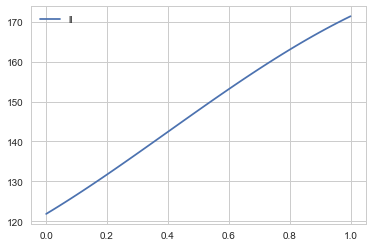

In [118]:
plot(ths,[np.sum([decomp2(a,b.spin(T))[slice()] for a,b,bn  in lines]) for T in Rs], label='ll')
# plot(ths,[np.sum([decomp2(a,b.spin(T))[slice(0)] for a,b,bn  in lines])  for T in Rs], label='kk')
legend()

In [22]:
def estimate_motors(dataset, 
                    noisy=False):
    
    points, motor = dataset
    if noisy:
        initial_motor = motor
    else:
        initial_motor = vsr.Mot(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

    
    mes = MotorEstimationSolver(initial_motor)
    if noisy:
        for (a, _, bn) in points:
            mes.add_point_correspondences_residual_block(a,bn)
    else:
        for (a, b, _) in points:
            mes.add_point_correspondences_residual_block(a,b)
#     mes.set_parameterization('BIVECTOR_GENERATOR')
    mes.set_parameterization('POLAR_DECOMPOSITION_TANGENT')
    mes.linear_solver_type = 'DENSE_QR'
    mes.max_num_iterations=20
    (estimated_motor, summary, _) = mes.solve()
    if len(pd.DataFrame(summary['iterations'])['cost']) > 20:
        converged = False
    else:
        converged = True
    return points, motor, estimated_motor, summary

In [23]:
motor1 = create_motors(1)[0]
dataset = create_points(motor1)
points, motor, estimated_motor, _ = estimate_motors(dataset)
print(motor)
print(estimated_motor)

motor2 = create_motors(1)[0]
dataset2 = ([(a.spin(motor2), b.spin(motor2), bn.spin(motor2)) for a,b,bn in points], 
            (vsr.CGA(motor1).spin(vsr.CGA(motor2))).mot())

points2, motor2, estimated_motor2, _ = estimate_motors(dataset2)
print(motor2)
print(estimated_motor2)

Mot: [ 0.94 0.28 -0.14 0.11 -2.2 -3.8 -0.87 -1.1 ]
Mot: [ 0.94 0.28 -0.14 0.11 -2.2 -3.8 -0.87 -1.1 ]
Mot: [ 0.94 0.28 0.11 0.13 -2.6 -1 -2.8 -1.1 ]
Mot: [ 0.94 0.28 0.11 0.13 -2.6 -1 -2.8 -1.1 ]


In [24]:
distpoints1 = np.sum([distance(a.vec(),b.vec()) for a,b,bn  in points])
distpoints2 = np.sum([distance(a.vec(),b.vec()) for a,b,bn  in points2])
print(distpoints1, distpoints2)

1042.93778826 1042.93778826


In [25]:
a = vsr.Vec(1,2,3).null()
b = vsr.Vec(2,3,4).null()
d1 = distance(a.vec(),b.vec())

In [26]:
d2 = distance(a.spin(motor1).vec(), b.spin(motor1).vec())

In [27]:
np.allclose(d1,d2)

True

In [28]:
def distance_innerprod(a,b):
    return a <= b

In [29]:
ds = np.linspace(0,1)
Ts = [vsr.Vec(0,0,d).trs() * vsr.Rot(1,0,0,0) for d in ds ]

In [30]:
a = vsr.Vec(0,0,0).null()
Ps = [a.spin(T) for T in Ts]

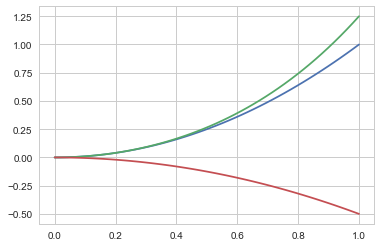

In [31]:
plot(ds,[distance(a.vec(), p.vec()) for p in Ps])
plot(ds, [distance(a, p) for p in Ps])
plot(ds, [distance_innerprod(a, p) for p in Ps])

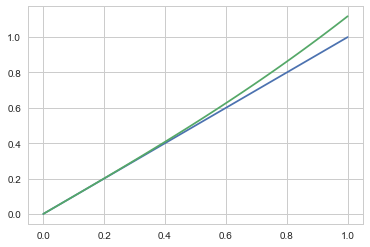

In [32]:
plot(ds,[np.sqrt(distance(a.vec(), p.vec())) for p in Ps])
plot(ds, [np.sqrt(distance(a, p)) for p in Ps])

In [133]:
a = vsr.Dlp(1,0,0,5)
b = vsr.Dlp(vsr.Vec(1,2,3).unit(), 9)

In [134]:
a.spin(motor)

Dlp: [ 0.8373 -0.2196 -0.5007 4.881 ]

In [140]:
np.inner(np.array(a) - np.array(b), np.array(a) - np.array(b))

17.465477516175152

In [142]:
distance(a,b)

17.465477516175152

In [143]:
distance(a.spin(motor), b.spin(motor))

103.2374940037185

In [138]:
b

Dlp: [ 0.2673 0.5345 0.8018 9 ]

In [139]:
a - b

Mot: [ 0 0 0 0 0 0 0 0 ]